# Proyecto Final  

Pablo Izquierdo Conde

Jorge Pose Eiroa

La primera parte del Proyecto consiste en obtener las páginas con las que vamos a trabajar. Para ello seleccionamos dos categorías de la Wikipedia, que en nuestro caso, y por ser las categorías iniciales muy disjuntas, el profesor nos ha permitido escoger dos subcategorías de la categoría "Sports".

In [105]:
import wikipediaapi as wk

wiki = wk.Wikipedia('en')

# Cogemos las categorías seleccionadas
#cat1 = wiki.page("Category:Esports")
#cat2 = wiki.page("Category:Combat_sports")

cat1 = wiki.page("Category:Geometry")
cat2 = wiki.page("Category:Combat_sports")

Una vez seleccionadas las categorías es necesario obtener las páginas que cuelgan de ellas, así como algunas de las páginas que cuelgan de las subcategorías de las categorías elegidas. Esto es lo que hace la siguiente función, a la que le hemos puesto una profundidad de 3 niveles, que es más que suficiente para obtener el número de páginas necesarias.

In [106]:
# Función que busca recursivamente en las categorías y nos devuelve una lista con las páginas
def print_categorymembers(categorymembers, level=0, max_level=2, pages = []):
    for c in categorymembers.values():
        if c.ns == 0: # Sacamos las páginas (ns=0)
            pages.append(c)
            # print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
        if c.ns == wk.Namespace.CATEGORY and level <= max_level:
            print_categorymembers(c.categorymembers, level + 1,1, pages)
p1 = []
p2 = []
print_categorymembers(cat1.categorymembers,0,1, p1)
print_categorymembers(cat2.categorymembers,0,1, p2)

Una vez obtenidas las páginas es necesario sacar el texto de las mismas, para ello vamos a hacer una permutación aleatoria de los índices para poder coger 1000 páginas por categoría de forma aleatoria para el conjunto de entrenamiento, y otras 200 para el conjunto de test.

In [109]:
import numpy as np

indices1 = np.random.permutation(len(p1))
indices2 = np.random.permutation(len(p2))

ind1_train = indices1[:1000]
ind1_test = indices1[1000:1200]

ind2_train = indices2[:1000]
ind2_test = indices2[1000:1200]

In [110]:
print(len(ind1_train))
print(len(ind1_test))
print(len(ind2_train))
print(len(ind2_test))

1000
200
1000
200


Una vez obtenidos los índices, procedemos a obtener el texto que usaremos como corpus para el resto del proyecto. Este proceso va a llevar un rato, ya que es necesario recorrer todas las páginas y descargar el texto.

In [111]:
# Sacamos el texto de las listas de páginas
corpus0_train = []
corpus1_train = []

# Corpus 0 train
print('Corpus 0 train')
for n,i in enumerate(ind1_train):
    if not n%100:
        print('\rPage', n, 'out of', len(ind1_train), end='', flush=True)
    corpus0_train.append(p1[i].text)
     
# Corpus 1 train    
print('\nCorpus 1 train')
for n,i in enumerate(ind2_train):
    if not n%100:
        print('\rPage', n, 'out of', len(ind2_train), end='', flush=True)
    corpus1_train.append(p2[i].text)
    

Corpus 0 train
Page 900 out of 1000
Corpus 1 train
Page 900 out of 1000

In [112]:
corpus0_test = []
corpus1_test = []

# Corpus 0 test    
print('\nCorpus 0 test')
for n,i in enumerate(ind1_test):
    if not n%100:
        print('\rPage', n, 'out of', len(ind1_test), end='', flush=True)
    corpus0_test.append(p1[i].text)
    
# Corpus 1 test    
print('\nCorpus 1 test')
for n,i in enumerate(ind2_test):
    if not n%100:
        print('\rPage', n, 'out of', len(ind2_test), end='', flush=True)
    corpus1_test.append(p2[i].text)


Corpus 0 test
Page 100 out of 200
Corpus 1 test
Page 100 out of 200

In [7]:
print(len(corpus0))
print(len(corpus1))

NameError: name 'corpus0' is not defined

# 2. Procesado de texto

    1. Tokenization
    2. Homogeneization
    3. Cleaning
    4. Vectorization

In [113]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wnl = WordNetLemmatizer()
stopwords_en = stopwords.words('english')

In [114]:
palabros = ['wa','also','ha']

stopwords_en.extend(palabros)

#print(stopwords_en)

In [115]:
def getCorpusClean(corpus):
    corpus_clean=[]
    for text in corpus:
        tokens = word_tokenize(text)
        tokens_filtered = [el.lower() for el in tokens if el.isalnum() and not el.isdigit()] # Nos quedamos solo con palabras, quitamos numeros
        tk_lemmat = [wnl.lemmatize(el) for el in tokens_filtered]
        tk_clean = [tk for tk in tk_lemmat if tk not in stopwords_en]
        corpus_clean.append(tk_clean)
    return corpus_clean

corpus0_trclean = getCorpusClean(corpus0_train)
corpus1_trclean = getCorpusClean(corpus1_train)
corpus0_testclean = getCorpusClean(corpus0_test)
corpus1_testclean = getCorpusClean(corpus1_test)

#for text in corpus0_train:
#    tokens = word_tokenize(text)
#    tokens_filtered = [el.lower() for el in tokens if el.isalnum() and not el.isdigit()] # Nos quedamos solo con palabras, quitamos numeros
#    tk_lemmat = [wnl.lemmatize(el) for el in tokens_filtered]
#    tk_clean = [tk for tk in tk_lemmat if tk not in stopwords_en]
#    corpus0_trclean.append(tk_clean)


In [116]:
print(len(corpus0_trclean))
print(len(corpus1_trclean))
print(len(corpus0_testclean))
print(len(corpus1_testclean))

1000
1000
200
200


In [117]:
import gensim

def getCorpusBow(corpus_clean, no_below = 5, no_above = .75):
    D = gensim.corpora.Dictionary(corpus_clean)
    D.filter_extremes(no_below=no_below, no_above=no_above, keep_n=25000)
    corpus_bow = [D.doc2bow(doc) for doc in corpus_clean]
    return corpus_bow, D
    
corpus0_trbow, D0_tr = getCorpusBow(corpus0_trclean)
corpus1_trbow, D1_tr = getCorpusBow(corpus1_trclean)
corpus0_testbow, D0_test = getCorpusBow(corpus0_testclean)
corpus1_testbow, D1_test = getCorpusBow(corpus1_testclean)

# 3. Modelado de tópicos con LDA

In [118]:
def getLDAModel(corpus_bow, D, num_topics):
    ldag = gensim.models.ldamodel.LdaModel(corpus=corpus_bow, id2word=D, num_topics = num_topics)
    return ldag

num_topics = 50
ldag0_tr = getLDAModel(corpus0_trbow, D0_tr, num_topics)
ldag1_tr = getLDAModel(corpus1_trbow, D1_tr, num_topics)
ldag0_test = getLDAModel(corpus0_testbow, D0_test, num_topics)
ldag1_test = getLDAModel(corpus1_testbow, D1_test, num_topics)

In [127]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

def visTopics(ldag, corpus_bow, D):    
    vis_data = gensimvis.prepare(ldag, corpus_bow, D)
    return pyLDAvis.display(vis_data)   

In [130]:
visTopics(ldag0_tr, corpus0_trbow, D0_tr)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [131]:
visTopics(ldag1_tr, corpus1_trbow, D1_tr)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [120]:
def getExpandedMatrix(corpus_bow, ldag, num_topics):
        reduced_corpus = [el for el in ldag[corpus_bow[:]]]
        X = gensim.matutils.corpus2dense(reduced_corpus, num_topics).T
        return X

X0 = getExpandedMatrix(corpus0_trbow, ldag0_tr, num_topics)
y0 = np.zeros((1000,1))
X1 = getExpandedMatrix(corpus1_trbow, ldag1_tr, num_topics)
y1 = np.ones((1000,1))

X0_test = getExpandedMatrix(corpus0_testbow, ldag0_test, num_topics)
X1_test = getExpandedMatrix(corpus1_testbow, ldag1_test, num_topics)


print(X0.shape, X1.shape)
print(X0_test.shape, X1_test.shape)

(1000, 50) (1000, 50)
(200, 50) (200, 50)


In [121]:
Xtrain = np.vstack((X0, X1))
ytrain = np.vstack((y0,y1))

#Xtest = np.vstack((X0_test, X1_test))


print(Xtrain.shape)
print(ytrain.shape)
#print(Xtest.shape)

(2000, 50)
(2000, 1)


# 4. Implementación del clasificador

In [122]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import sklearn.model_selection as modselect

# Normalizamos los datos
#Xtrain = scale(Xtrain)
# Probar a ver si esto mejora o no

In [ ]:
# Preparamos los parámetros para la validación cruzada
C_all = np.logspace(-3,4,10)

Gamma = np.linspace(0.1,1,100)
C_score = []

for g in Gamma:
    clf = svm.SVC(kernel = 'rbf', C=1669, gamma=g)
    scores = cross_val_score(clf, Xtrain, np.ravel(ytrain), 
                             cv = 10, scoring = 'accuracy')
    
    C_score.append(np.mean(scores))

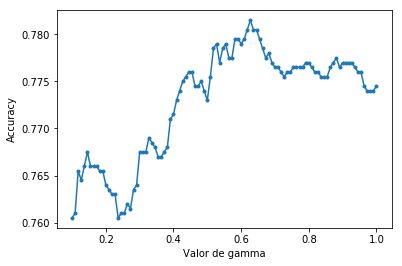

In [47]:
plt.figure()
plt.plot(Gamma,C_score,'.-')
plt.xlabel('Valor de gamma')
plt.ylabel('Accuracy')
plt.show()

In [44]:
C_opt = C_all[np.argmax(C_score)]
print(C_opt)

1668.100537200059


In [49]:
G_opt = Gamma[np.argmax(C_score)]
print(G_opt)

0.6272727272727272


In [123]:
from sklearn.model_selection import LeaveOneOut
C_opt = 1669
g_opt = 0.63

loo = LeaveOneOut()
clf = svm.SVC(kernel = 'rbf')


In [124]:
svcparams = {'C': [500, 1000, 1200, 1500 ],
     'gamma': [0.7, 0.9, 1.1]}

svcGrid = modselect.GridSearchCV(clf, svcparams, cv=20, verbose=1, scoring='accuracy', n_jobs=-2).fit(Xtrain,np.ravel(ytrain))
print('finish')

Fitting 20 folds for each of 12 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed:   20.0s finished


finish


In [125]:
print('best_score', svcGrid.best_score_)
print('best_params', svcGrid.best_params_)

best_score 0.711
best_params {'C': 500, 'gamma': 0.7}


In [89]:
scores = cross_val_score(clf, Xtrain, np.ravel(ytrain), 
                             cv = 50, scoring = 'accuracy')
print(np.mean(scores))

0.69


In [126]:
clf = svm.SVC(kernel = 'rbf', C=500, gamma=0.7)
clf.fit(Xtrain,np.ravel(ytrain))
Y0_test=clf.predict(X0_test)
Y1_test=clf.predict(X1_test)
print(Y0_test.shape)
print(Y1_test.shape)
print(Y0_test)
print(1-np.count_nonzero(Y0_test)/len(Y0_test))
print(np.count_nonzero(Y1_test)/len(Y1_test))

(200,)
(200,)
[1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 1.]
0.43999999999999995
0.59
